In [ ]:
#The original time is in UTC. we need to make it to America/New_York time

In [ ]:
import pandas as pd

scooter_df = pd.read_csv('washington_dc_scooter.csv')
bike_df = pd.read_csv('washington_dc_bike.csv')

print("Scooter DataFrame Head:")
print(scooter_df.head())

print("\nBike DataFrame Head:")
print(bike_df.head())


Scooter DataFrame Head:
              id     olat     olng     dlat     dlng                  ots  \
0  222OPEOGXJPJW  38.8712 -77.0060  38.8794 -77.0038  2023-05-06 19:17:05   
1  222OPEOGXJPJW  38.8715 -77.0075  38.8878 -77.0286  2023-02-20 00:51:06   
2  222OPEOGXJPJW  38.8716 -77.0071  38.8748 -77.0052  2023-07-04 19:34:05   
3  222OPEOGXJPJW  38.8718 -77.0061  38.8734 -76.9917  2023-08-16 02:12:06   
4  222OPEOGXJPJW  38.8720 -77.0097  38.8936 -77.0114  2023-08-22 08:08:05   

   duration     distance  vehicle                  dts     speed  
0       540   931.475362  scooter  2023-05-06 19:26:05  1.724954  
1      1619  2573.127232  scooter  2023-02-20 01:18:05  1.589331  
2       300   392.001017  scooter  2023-07-04 19:39:05  1.306670  
3      1019  1259.240539  scooter  2023-08-16 02:29:05  1.235761  
4      1201  2406.313738  scooter  2023-08-22 08:28:06  2.003592  

Bike DataFrame Head:
              id     olat     olng     dlat     dlng                  ots  \
0  224532QI7

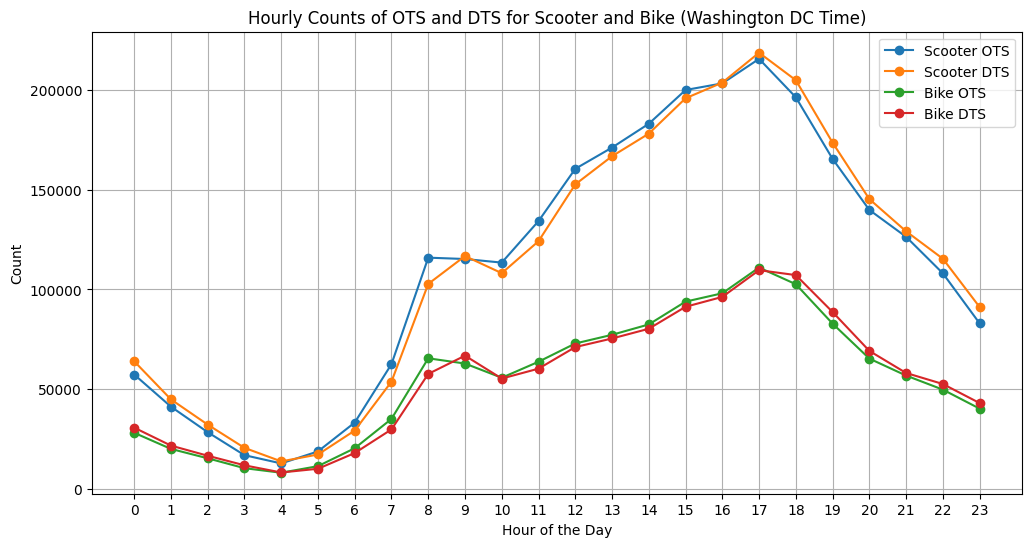

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz

# Convert ots and dts columns to datetime format
scooter_df['ots'] = pd.to_datetime(scooter_df['ots'])
scooter_df['dts'] = pd.to_datetime(scooter_df['dts'])
bike_df['ots'] = pd.to_datetime(bike_df['ots'])
bike_df['dts'] = pd.to_datetime(bike_df['dts'])

# Define UTC and Washington DC time zones
utc = pytz.utc
dc_tz = pytz.timezone('America/New_York')

# Convert time to Washington DC time
scooter_df['ots'] = scooter_df['ots'].dt.tz_localize(utc).dt.tz_convert(dc_tz)
scooter_df['dts'] = scooter_df['dts'].dt.tz_localize(utc).dt.tz_convert(dc_tz)
bike_df['ots'] = bike_df['ots'].dt.tz_localize(utc).dt.tz_convert(dc_tz)
bike_df['dts'] = bike_df['dts'].dt.tz_localize(utc).dt.tz_convert(dc_tz)

# Extract hour information
scooter_df['ots_hour'] = scooter_df['ots'].dt.hour
scooter_df['dts_hour'] = scooter_df['dts'].dt.hour
bike_df['ots_hour'] = bike_df['ots'].dt.hour
bike_df['dts_hour'] = bike_df['dts'].dt.hour

# Aggregate counts for each hour
scooter_ots_count = scooter_df['ots_hour'].value_counts().sort_index()
scooter_dts_count = scooter_df['dts_hour'].value_counts().sort_index()
bike_ots_count = bike_df['ots_hour'].value_counts().sort_index()
bike_dts_count = bike_df['dts_hour'].value_counts().sort_index()

# Create a DataFrame to display the results
hourly_counts = pd.DataFrame({
    'scooter_ots_count': scooter_ots_count,
    'scooter_dts_count': scooter_dts_count,
    'bike_ots_count': bike_ots_count,
    'bike_dts_count': bike_dts_count
}).fillna(0).astype(int)

# Draw a line chart
plt.figure(figsize=(12, 6))

# Scooter OTS
plt.plot(hourly_counts.index, hourly_counts['scooter_ots_count'], label='Scooter OTS', marker='o')
# Scooter DTS
plt.plot(hourly_counts.index, hourly_counts['scooter_dts_count'], label='Scooter DTS', marker='o')
# Bike OTS
plt.plot(hourly_counts.index, hourly_counts['bike_ots_count'], label='Bike OTS', marker='o')
# Bike DTS
plt.plot(hourly_counts.index, hourly_counts['bike_dts_count'], label='Bike DTS', marker='o')

plt.title('Hourly Counts of OTS and DTS for Scooter and Bike (Washington DC Time)')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))

plt.show()


In [ ]:
pip install --upgrade osmnx

In [ ]:
# After cleaning LS and LB data, we need to handle them separately. We will analyze LS first.

In [ ]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
from scipy.spatial import KDTree
import numpy as np

# Load the CSV file
df = pd.read_csv('washington_dc_scooter.csv')

# Load the road network shapefile
road_network = gpd.read_file('Roadway_Block.shp')


In [ ]:
df['ots'] = pd.to_datetime(df['ots'])

In [ ]:
num_rows = df.shape[0]
num_rows

2703025

In [ ]:
# Build the graph from the road network shapefile
G = nx.Graph()
nodes = []

for _, row in road_network.iterrows():
    geom = row.geometry
    if geom and geom.geom_type == 'LineString':
        coords = list(geom.coords)
        nodes.extend(coords)
        for i in range(len(coords) - 1):
            G.add_edge(coords[i], coords[i + 1], weight=LineString([coords[i], coords[i + 1]]).length)

# Remove duplicate nodes and create KDTree
unique_nodes = list(set(nodes))
node_coords = np.array(unique_nodes)
kdtree = KDTree(node_coords[:, :2])  # Only take the first two dimensions for 2D coordinates

# Function to find the nearest node in the graph using KDTree
def get_nearest_node(point, kdtree, node_coords):
    dist, idx = kdtree.query([point.x, point.y])
    return tuple(node_coords[idx])

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed

# Function to process a batch
def process_batch(batch_df):
    paths = []
    for _, row in batch_df.iterrows():
        start_point = Point(row['olng'], row['olat'])
        end_point = Point(row['dlng'], row['dlat'])

        start_node = get_nearest_node(start_point, kdtree, node_coords)
        end_node = get_nearest_node(end_point, kdtree, node_coords)

        if start_node and end_node:
            try:
                shortest_path_nodes = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
                if len(shortest_path_nodes) > 1:  # Ensure there are more than one point
                    shortest_path = LineString(shortest_path_nodes)
                    paths.append(shortest_path)
                else:
                    paths.append(None)
            except nx.NetworkXNoPath:
                paths.append(None)
        else:
            paths.append(None)
    return batch_df.assign(geometry=paths)

# Function to process batches in parallel
def process_batches_in_parallel(df, batch_size, num_workers):
    num_batches = len(df) // batch_size + 1
    futures = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for i in range(num_batches):
            batch_df = df.iloc[i * batch_size: (i + 1) * batch_size]
            print(f"Submitting batch {i + 1} of {num_batches}...")
            futures.append(executor.submit(process_batch, batch_df))

        for i, future in enumerate(as_completed(futures)):
            batch_result = future.result()
            batch_result['ots'] = batch_result['ots'].astype(str)
            batch_result['dts'] = batch_result['dts'].astype(str)
            batch_output_file = f'escooter_shortest_paths_{i + 1}.shp'
            gdf_batch = gpd.GeoDataFrame(batch_result, geometry='geometry')
            gdf_batch.to_file(batch_output_file)
            print(f"Batch {i + 1} processed and saved to {batch_output_file}")

# Process the DataFrame in parallel
process_batches_in_parallel(df, batch_size=100000, num_workers=4)

print("All batches processed.")

Submitting batch 1 of 28...
Submitting batch 2 of 28...
Submitting batch 3 of 28...
Submitting batch 4 of 28...
Submitting batch 5 of 28...
Submitting batch 6 of 28...
Submitting batch 7 of 28...
Submitting batch 8 of 28...
Submitting batch 9 of 28...
Submitting batch 10 of 28...
Submitting batch 11 of 28...
Submitting batch 12 of 28...
Submitting batch 13 of 28...
Submitting batch 14 of 28...
Submitting batch 15 of 28...
Submitting batch 16 of 28...
Submitting batch 17 of 28...
Submitting batch 18 of 28...
Submitting batch 19 of 28...
Submitting batch 20 of 28...
Submitting batch 21 of 28...
Submitting batch 22 of 28...
Submitting batch 23 of 28...
Submitting batch 24 of 28...
Submitting batch 25 of 28...
Submitting batch 26 of 28...
Submitting batch 27 of 28...
Submitting batch 28 of 28...
Batch 1 processed and saved to /content/drive/MyDrive/Colab Notebooks/Dan/escooter_shortest_paths_1.shp
Batch 2 processed and saved to /content/drive/MyDrive/Colab Notebooks/Dan/escooter_shortest_p

In [ ]:
import geopandas as gpd
import os
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
from scipy.spatial import KDTree
import numpy as np
import pytz


# 定义文件路径
file_paths = [
    'escooter_shortest_paths_1.shp',
    'escooter_shortest_paths_2.shp',
    'escooter_shortest_paths_3.shp',
    'escooter_shortest_paths_4.shp',
    'escooter_shortest_paths_5.shp',
    'escooter_shortest_paths_6.shp',
    'escooter_shortest_paths_7.shp',
    'escooter_shortest_paths_8.shp',
    'escooter_shortest_paths_9.shp',
    'escooter_shortest_paths_10.shp',
    'escooter_shortest_paths_11.shp',
    'escooter_shortest_paths_12.shp',
    'escooter_shortest_paths_13.shp',
    'escooter_shortest_paths_14.shp',
    'escooter_shortest_paths_15.shp',
    'escooter_shortest_paths_16.shp',
    'escooter_shortest_paths_17.shp',
    'escooter_shortest_paths_18.shp',
    'escooter_shortest_paths_19.shp',
    'escooter_shortest_paths_20.shp',
    'escooter_shortest_paths_21.shp',
    'escooter_shortest_paths_22.shp',
    'escooter_shortest_paths_23.shp',
    'escooter_shortest_paths_24.shp',
    'escooter_shortest_paths_25.shp',
    'escooter_shortest_paths_26.shp',
    'escooter_shortest_paths_27.shp',
    'escooter_shortest_paths_28.shp'
]

# 读取并合并所有shapefile
gdf_list = [gpd.read_file(file) for file in file_paths]
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))


In [ ]:
# Convert 'ots' column to datetime
combined_gdf['ots'] = pd.to_datetime(combined_gdf['ots'])

# Define UTC and Washington DC time zones
utc = pytz.utc
dc_tz = pytz.timezone('America/New_York')

# Convert time to Washington DC time
combined_gdf['ots'] = combined_gdf['ots'].dt.tz_localize(utc).dt.tz_convert(dc_tz)
combined_gdf['dts'] = combined_gdf['dts'].dt.tz_localize(utc).dt.tz_convert(dc_tz)

# Extract month from 'ots' column
combined_gdf['month'] = combined_gdf['ots'].dt.month

combined_gdf['ots'] = combined_gdf['ots'].astype(str)
# Split the dataset into 12 months and save separately
for month in range(1, 13):
    monthly_gdf = combined_gdf[combined_gdf['month'] == month]
    output_file = f'escooter_trajectory2023_month_{month}.shp'
    monthly_gdf.to_file(output_file)


In [ ]:

import pytz
import geopandas as gpd
import pandas as pd

# Define a function to process a single file
def process_file(month):
    # Construct the filename
    filename = f'escooter_trajectory2023_month_{month}.shp'

    # Read the shapefile
    cleaned_gdf = gpd.read_file(filename)

    # Set the initial CRS to WGS 1984 (EPSG:4326)
    cleaned_gdf.set_crs(epsg=4326, inplace=True)

    # Transform the CRS to the projection coordinate system of Washington DC area (EPSG:3559)
    cleaned_gdf = cleaned_gdf.to_crs(epsg=3559)

    # Convert the 'ots' column to datetime type
    cleaned_gdf['ots'] = pd.to_datetime(cleaned_gdf['ots'])

    # convert to NYC time
    utc = pytz.utc
    dc_tz = pytz.timezone('America/New_York')
    cleaned_gdf['ots'] = cleaned_gdf['ots'].dt.tz_localize(utc).dt.tz_convert(dc_tz)

    # Generate 'Y_or_D' column to determine whether it's a weekday or weekend
    cleaned_gdf['Y_or_D'] = cleaned_gdf['ots'].dt.weekday.apply(lambda x: 'Y' if x < 5 else 'D')

    # Generate 'hour' column to categorize by hour
    cleaned_gdf['hour'] = cleaned_gdf['ots'].dt.hour

    road_block_gdf = gpd.read_file('Roadway_Block.shp')
    road_block_gdf = road_block_gdf.to_crs(epsg=3559)

    # Define all combinations
    combinations = cleaned_gdf.groupby(['Y_or_D', 'hour']).size().reset_index(name='count')

    # Create a new column to store the count for each combination
    for index, row in combinations.iterrows():
        column_name = f"{row['Y_or_D']}_{row['hour']}"
        road_block_gdf[column_name] = 0

    # Perform spatial join and count for each group
    for index, row in combinations.iterrows():
        y_or_d = row['Y_or_D']
        hour = row['hour']
        column_name = f"{y_or_d}_{hour}"

        subset = cleaned_gdf[(cleaned_gdf['Y_or_D'] == y_or_d) & (cleaned_gdf['hour'] == hour)]

        # Buffer processing
        road_block_buffer = road_block_gdf.copy()
        road_block_buffer['geometry'] = road_block_buffer.geometry.buffer(50)

        # Perform spatial join
        sjoin_result = gpd.sjoin(subset, road_block_buffer, how='inner', op='intersects')

        # Count each road block
        count_series = sjoin_result['index_right'].value_counts()

        # Update the count in road_block_gdf
        for idx, count in count_series.items():
            road_block_gdf.at[idx, column_name] = count

    # Save the updated Road_Block
    road_block_gdf.to_file(f'escooter{month:02d}_trajectory_count_hourly.shp')

    print(f"Updated Road_Block shapefile for month {month} has been saved")

# Process files for months 1-12
for month in range(1, 13):
    process_file(month)


In [ ]:
import geopandas as gpd
import pandas as pd

# Define file paths and seasons
season_files = {
    'Wi': ['escooter01_trajectory_count_hourly.shp', 'escooter02_trajectory_count_hourly.shp', 'escooter12_trajectory_count_hourly.shp'],
    'Sp': ['escooter03_trajectory_count_hourly.shp', 'escooter04_trajectory_count_hourly.shp', 'escooter05_trajectory_count_hourly.shp'],
    'Su': ['escooter06_trajectory_count_hourly.shp', 'escooter07_trajectory_count_hourly.shp', 'escooter08_trajectory_count_hourly.shp'],
    'Fa': ['escooter09_trajectory_count_hourly.shp', 'escooter10_trajectory_count_hourly.shp', 'escooter11_trajectory_count_hourly.shp'],
    'All': ['escooter01_trajectory_count_hourly.shp', 'escooter02_trajectory_count_hourly.shp', 'escooter03_trajectory_count_hourly.shp',
            'escooter04_trajectory_count_hourly.shp', 'escooter05_trajectory_count_hourly.shp', 'escooter06_trajectory_count_hourly.shp',
            'escooter07_trajectory_count_hourly.shp', 'escooter08_trajectory_count_hourly.shp', 'escooter09_trajectory_count_hourly.shp',
            'escooter10_trajectory_count_hourly.shp', 'escooter11_trajectory_count_hourly.shp', 'escooter12_trajectory_count_hourly.shp']
}

# Initialize an empty GeoDataFrame to store sums
combined_gdf = None
seasonal_gdfs = {season: None for season in season_files}

# Select a file to retain the geometry column
geometry_gdf = gpd.read_file(season_files['All'][0])
geometry_gdf = geometry_gdf[['ID', 'geometry']]

# Define the columns to be processed
columns = [f'D_{i}' for i in range(24)] + [f'Y_{i}' for i in range(24)]

# Process each season and all files
for season, files in season_files.items():
    for file_path in files:
        gdf = gpd.read_file(file_path)
        # Check for missing columns and add them with zeros if necessary
        for col in columns:
            if col not in gdf.columns:
                gdf[col] = 0
        # Retain the ID column and columns to be summed
        gdf = gdf[['ID'] + columns]

        if season == 'All':
            if combined_gdf is None:
                combined_gdf = gdf.rename(columns={col: f'All_{col}' for col in columns}).copy()
            else:
                for col in columns:
                    combined_gdf[f'All_{col}'] += gdf[col]
        else:
            if seasonal_gdfs[season] is None:
                seasonal_gdfs[season] = gdf.copy()
            else:
                for col in columns:
                    seasonal_gdfs[season][col] += gdf[col]

# Merge all seasonal data into combined_gdf
for season, gdf in seasonal_gdfs.items():
    if season != 'All':
        gdf = gdf.rename(columns={col: f'{season}_{col}' for col in columns})
        combined_gdf = combined_gdf.merge(gdf, on='ID')

# Merge the geometry column
combined_gdf = combined_gdf.merge(geometry_gdf, on='ID')

# Ensure combined_gdf is a GeoDataFrame
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')

# Debug output column names
print("Combined columns:", combined_gdf.columns)

# Save the merged GeoDataFrame as a new shapefile
combined_gdf.to_file('escooter2023_trajectory_hourly_count.shp')


Combined columns: Index(['ID', 'All_D_0', 'All_D_1', 'All_D_2', 'All_D_3', 'All_D_4', 'All_D_5',
       'All_D_6', 'All_D_7', 'All_D_8',
       ...
       'Fa_Y_15', 'Fa_Y_16', 'Fa_Y_17', 'Fa_Y_18', 'Fa_Y_19', 'Fa_Y_20',
       'Fa_Y_21', 'Fa_Y_22', 'Fa_Y_23', 'geometry'],
      dtype='object', length=242)


In [ ]:
#STA for LS

In [ ]:
# Step 1: Clone the repository
!git clone https://github.com/hichamjanati/spatio-temporal-alignements.git


Cloning into 'spatio-temporal-alignements'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 120 (delta 2), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (120/120), 31.18 MiB | 31.09 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
# Step 2: Change directory to the cloned repository
%cd /content/spatio-temporal-alignements/sta

/content/spatio-temporal-alignements/sta


In [ ]:
# Step 4: Install the package
!pip install .

Processing /content/spatio-temporal-alignements/sta
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 868.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-3.0.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sta: filename=sta-0.0.1-py3-none-any.whl size=11510 sha256=c14b50660a1daba0f40d943034d6d1c5fe0ef9f6265513d40c1825818c54c515
  Stored in directory: /tmp/pip-ephem-wheel-cache-skgkhcs2/wheels/b6/95/aa/85cdbeeffa56374bf6c026264b6f09c4c15407c4274f65cb0d
  Created wheel for soft-dtw: filename=soft_dtw-0.1.6-cp310-cp310-linux_x86_64.whl size=122993 sha256=1150d10dd03b82cc300cb8eed38ac3cbbbc82cfc1cb68091956925ca05302844
  Stored in directory: /root/.cache/pip/wheels/6a/95/c4/cabf83a0bbd365380717dc06170aefe33ff8707dabf179e84a
  Created wheel for chai

In [ ]:
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.8 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import collections
from sta import sta_distances, sta_matrix
from sta.utils import cost_matrix, tonumpy
import torch

from scipy.cluster.vq import kmeans2, whiten
from scipy.spatial.distance import cdist

In [ ]:
drivepath = "escooter2023_trajectory_hourly_count.shp"
gdf = gpd.read_file(drivepath)

In [ ]:
gdf = gdf.drop(index=5242)

In [ ]:
geo = gdf['geometry'];

midpoints = []
for i, geom in enumerate(gdf.geometry):
    if isinstance(geom, LineString):
        midpoint = geom.interpolate(0.5, normalized=True)
        midpoints.append((midpoint.x, midpoint.y))
    else:
        print(f"Geometry at index {i} is not a LineString: {type(geom)}")

print("Midpoints calculated.")
midpoints = np.array(midpoints);

# find four corners of the geometry
xmaxp = midpoints[np.argmax(midpoints[:,0])]
xminp = midpoints[np.argmin(midpoints[:,0])]
ymaxp = midpoints[np.argmax(midpoints[:,1])]
yminp = midpoints[np.argmin(midpoints[:,1])]

# define a parallelogram using three corners
p1 = ymaxp
p2 = xmaxp
p3 = xminp
b1 = p2 - p1
b2 = p3 - p1
n1 = np.array([-b1[1], b1[0]]) / np.linalg.norm(b1)
n2 = np.array([-b2[1], b2[0]]) / np.linalg.norm(b2)
A = np.vstack([n1, n2]);

# get bounds for the c coordinates

c1_min = min([np.dot(x,n1) for x in midpoints])
c1_max = max([np.dot(x,n1) for x in midpoints])

c2_min = min([np.dot(x,n2) for x in midpoints])
c2_max = max([np.dot(x,n2) for x in midpoints])

c_min = np.array([c1_min, c2_min])
c_max = np.array([c1_max, c2_max])

def x2r(x):
  c = np.dot(A,x)
  c_diff = c_max - c_min
  r = (c - c_min) / c_diff
  return r

def r2x(r):
  c_diff = c_max - c_min
  c = c_min + r * c_diff
  x = np.dot(np.linalg.inv(A),c)
  return x

rpoints = np.array([x2r(x) for x in midpoints])

Midpoints calculated.


In [ ]:
nx = 50
ny = 50
n_cluster = nx * ny
xcuts = np.linspace(0.35,1,nx+1)
ycuts = np.linspace(0,1,ny+1)

cluster_center_ind = np.zeros(len(rpoints),dtype=int)
cluster_center_coords = []
idx = 0
for i in range(len(xcuts)-1):
  for j in range(len(ycuts)-1):
      is_inx = np.logical_and(xcuts[i] < rpoints[:,0], rpoints[:,0] < xcuts[i+1])
      is_iny = np.logical_and(ycuts[j] < rpoints[:,1], rpoints[:,1] < ycuts[j+1])
      is_inxy = np.logical_and(is_inx, is_iny)
      cluster_center_ind[is_inxy] = idx
      r_coord = np.array([(xcuts[i]+xcuts[i+1])/2, (ycuts[j]+ycuts[j+1])/2])
      x_coord = r2x(r_coord)
      cluster_center_coords.append(x_coord)
      idx += 1
cluster_center_coords = np.array(cluster_center_coords)

# Constructing EMD Matrix
data_columns = [x for x in gdf.columns if x not in ['geometry']]
cluster_data = []
for col in data_columns:
  d = gdf[col]
  cluster_weight = []
  for i in range(0,n_cluster):
    cluster_weight.append(d[cluster_center_ind == i].sum())
  cluster_data.append(cluster_weight)

cluster_data = np.array(cluster_data)
cluster_data = cluster_data.T

gdf_cluster = pd.DataFrame(cluster_data, columns=data_columns)
gdf_cluster["x"] = cluster_center_coords[:,0]
gdf_cluster["y"] = cluster_center_coords[:,1]

cluster_center_r = np.array([x2r(x) for x in cluster_center_coords])
gdf_cluster["rx"] = cluster_center_r[:,0]
gdf_cluster["ry"] = cluster_center_r[:,1]

In [ ]:
col_to_img = lambda col: np.reshape(gdf_cluster[col],(nx,ny))
D_series1 = np.array([col_to_img(x) for x in ["All_D_6","All_D_7","All_D_8","All_D_9","All_D_10"]])
D_series2 = np.array([col_to_img(x) for x in ["All_D_11","All_D_12","All_D_13","All_D_14","All_D_15"]])
D_series3 = np.array([col_to_img(x) for x in ["All_D_16","All_D_17","All_D_18","All_D_19","All_D_20"]])
D_series4 = np.array([col_to_img(x) for x in ["All_D_21","All_D_22","All_D_23","All_D_0","All_D_1"]])

Y_series1 = np.array([col_to_img(x) for x in ["All_Y_6","All_Y_7","All_Y_8","All_Y_9","All_Y_10"]])
Y_series2 = np.array([col_to_img(x) for x in ["All_Y_11","All_Y_12","All_Y_13","All_Y_14","All_Y_15"]])
Y_series3 = np.array([col_to_img(x) for x in ["All_Y_16","All_Y_17","All_Y_18","All_Y_19","All_Y_20"]])
Y_series4 = np.array([col_to_img(x) for x in ["All_Y_21","All_Y_22","All_Y_23","All_Y_0","All_Y_1"]])

X_series = np.array([D_series1, D_series2,D_series3,D_series4,Y_series1, Y_series2,Y_series3,Y_series4])

In [ ]:
X_series

array([[[['322', '0', '0', ..., '5', '0', '0'],
         ['0', '0', '0', ..., '0', '2', '2'],
         ['0', '0', '0', ..., '7', '7', '8'],
         ...,
         ['0', '0', '2', ..., '4', '0', '84'],
         ['0', '0', '0', ..., '10', '0', '40'],
         ['0', '0', '8', ..., '74', '24', '63']],

        [['182', '0', '0', ..., '4', '0', '6'],
         ['0', '0', '0', ..., '0', '0', '2'],
         ['0', '0', '0', ..., '6', '4', '3'],
         ...,
         ['0', '0', '3', ..., '5', '4', '57'],
         ['3', '3', '6', ..., '9', '15', '20'],
         ['12', '20', '19', ..., '64', '74', '15']],

        [['357', '0', '0', ..., '3', '0', '22'],
         ['0', '0', '0', ..., '0', '0', '15'],
         ['0', '0', '0', ..., '9', '7', '19'],
         ...,
         ['0', '0', '1', ..., '4', '4', '64'],
         ['0', '0', '1', ..., '5', '7', '29'],
         ['0', '2', '6', ..., '114', '79', '48']],

        [['707', '0', '0', ..., '2', '1', '17'],
         ['0', '0', '0', ..., '0', '3', '7'],

In [ ]:
dimension=50

In [ ]:
epsilon = 0.01
_, M = cost_matrix(dimension)
K = tonumpy(torch.exp(- M / epsilon))

In [ ]:
betas = [0,0,0,0]

In [ ]:
for series in [D_series1, D_series2, D_series3, D_series4, Y_series1, Y_series2, Y_series3, Y_series4]:
    for i in range(series.shape[1]):
        series[:, i] = series[:, i].astype(float) / series[:, i].astype(float).sum()

In [ ]:
X_series = np.array([D_series1, D_series2,D_series3,D_series4,Y_series1, Y_series2,Y_series3,Y_series4])

In [ ]:
X_series.shape

(8, 5, 50, 50)

In [ ]:
X_series= X_series.astype(np.float64)

In [ ]:
staM = sta_matrix(X_series, betas, K, 0.01, 1.)[1]

Doing 0 / 8 ...
Doing 7 / 8 ...
Doing 1 / 8 ...
Doing 6 / 8 ...
Doing 2 / 8 ...
Doing 5 / 8 ...
Doing 3 / 8 ...
Doing 4 / 8 ...


In [ ]:
staM

array([[3.21479554e-07, 2.01647359e+00, 5.12641975e+00, 5.38851146e+00,
        1.31502057e+00, 1.34427523e+00, 5.62347516e+00, 1.09585531e+01],
       [2.01647359e+00, 8.79613866e-07, 8.70491640e-01, 1.25780282e+00,
        1.36800658e+00, 2.56822946e-01, 1.16735837e+00, 4.17454409e+00],
       [5.12641975e+00, 8.70491640e-01, 8.79743200e-07, 3.06139278e-01,
        2.95862454e+00, 1.40512669e+00, 2.40411385e-01, 1.52852230e+00],
       [5.38851146e+00, 1.25780282e+00, 3.06139278e-01, 5.91265213e-07,
        2.92808004e+00, 1.68520362e+00, 3.06036168e-01, 1.20020547e+00],
       [1.31502057e+00, 1.36800658e+00, 2.95862454e+00, 2.92808004e+00,
        3.22858647e-07, 1.21874900e+00, 2.41199089e+00, 6.08576874e+00],
       [1.34427523e+00, 2.56822946e-01, 1.40512669e+00, 1.68520362e+00,
        1.21874900e+00, 7.22070149e-07, 1.70359748e+00, 5.08504456e+00],
       [5.62347516e+00, 1.16735837e+00, 2.40411385e-01, 3.06036168e-01,
        2.41199089e+00, 1.70359748e+00, 7.21810228e-07, 1.

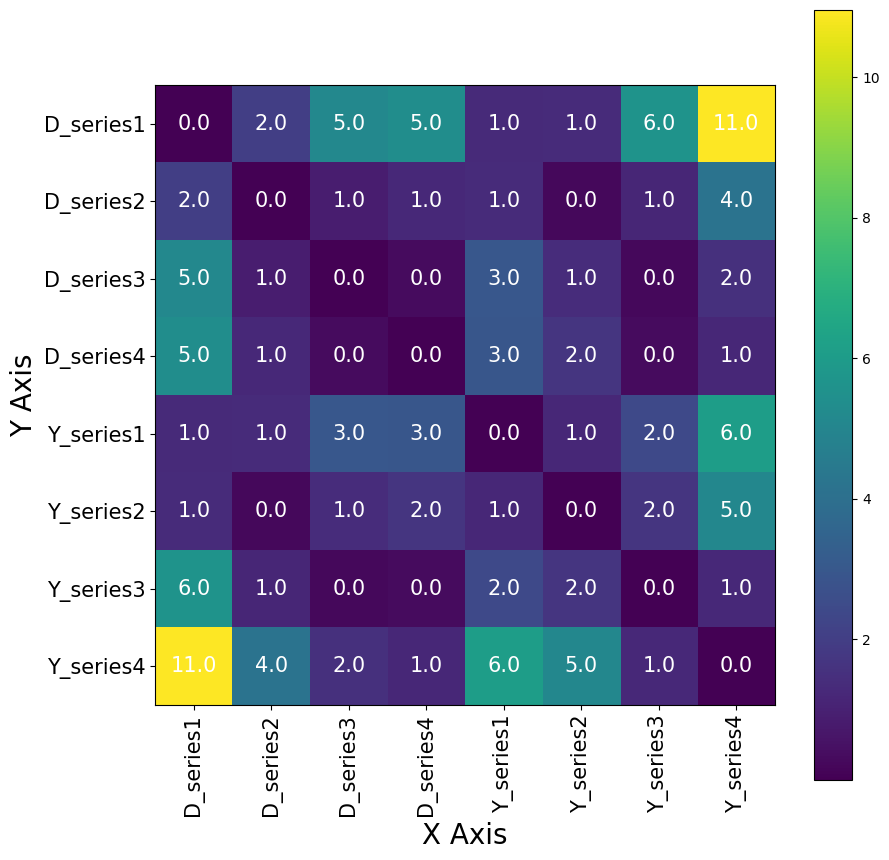

In [ ]:
row_and_column_names = ["D_series1", "D_series2", "D_series3", "D_series4", "Y_series1", "Y_series2", "Y_series3", "Y_series4"
]

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(staM, cmap='viridis')
for i in range(staM.shape[0]):
    for j in range(staM.shape[1]):
        text = plt.text(j, i, np.round(staM[i, j], 0),
                        ha="center", va="center", color="w", fontsize=15)

plt.xticks(ticks=np.arange(len(row_and_column_names)), labels=row_and_column_names, rotation=90,fontsize=15)
plt.yticks(ticks=np.arange(len(row_and_column_names)), labels=row_and_column_names,fontsize=15)
plt.colorbar()
plt.xlabel('X Axis', fontsize=20)
plt.ylabel('Y Axis', fontsize=20)
plt.show()


<ipython-input-43-b7b0d4e6bbe0>:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((df.shape[1], i - 0.5), 0.3, 1, fill=True, color='white', edgecolor='black'))


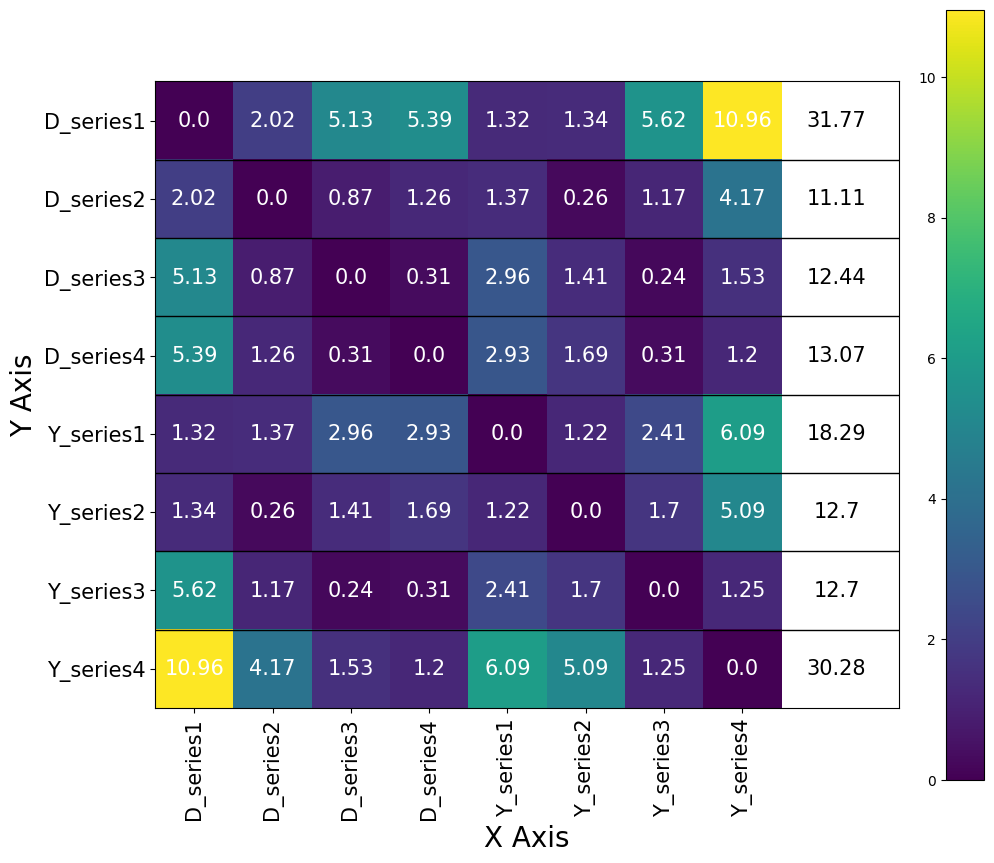

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming staM is your matrix, replace it with your actual matrix
staM = np.array([
    [0.00, 2.02, 5.13, 5.39, 1.32, 1.34, 5.62, 10.96, 31.77],
    [2.02, 0.00, 0.87, 1.26, 1.37, 0.26, 1.17, 4.17, 11.11],
    [5.13, 0.87, 0.00, 0.31, 2.96, 1.41, 0.24, 1.53, 12.44],
    [5.39, 1.26, 0.31, 0.00, 2.93, 1.69, 0.31, 1.20, 13.07],
    [1.32, 1.37, 2.96, 2.93, 0.00, 1.22, 2.41, 6.09, 18.29],
    [1.34, 0.26, 1.41, 1.69, 1.22, 0.00, 1.70, 5.09, 12.70],
    [5.62, 1.17, 0.24, 0.31, 2.41, 1.70, 0.00, 1.25, 12.70],
    [10.96, 4.17, 1.53, 1.20, 6.09, 5.09, 1.25, 0.00, 30.28]
])

row_and_column_names = ["D_series1", "D_series2", "D_series3", "D_series4", "Y_series1", "Y_series2", "Y_series3", "Y_series4"]

# Create DataFrame and add row and column names
df = pd.DataFrame(staM[:, :8], index=row_and_column_names, columns=row_and_column_names[:8])

# Plot the heatmap
plt.figure(figsize=(12, 10), dpi=100)  # Increase figure size and DPI
plt.imshow(df.values, cmap='viridis')  # Use viridis colormap for better contrast

# Display values inside the heatmap
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        text = plt.text(j, i, np.round(df.values[i, j], 2),  # Display rounded values
                        ha="center", va="center", color="w", fontsize=15)  # Increase font size

# Customize ticks and labels
plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, rotation=90, fontsize=15)
plt.yticks(ticks=np.arange(len(df.index)), labels=df.index, fontsize=15)

# Move colorbar to the left
cbar = plt.colorbar()
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

# Add small squares with last numbers in each row, with reduced width
for i in range(staM.shape[0]):
    plt.gca().add_patch(plt.Rectangle((df.shape[1], i - 0.5), 0.3, 1, fill=True, color='white', edgecolor='black'))
    plt.text(df.shape[1] + 0.2, i, np.round(staM[i, -1], 2),  # Display the last number with two decimals
             ha="center", va="center", color="black", fontsize=15)

# Adjust plot limits to make space for the additional squares
plt.xlim(-0.5, df.shape[1] + 1)
plt.ylim(df.shape[0] - 0.5, -0.5)

# Draw lines between rows
for i in range(1, df.shape[0]):
    plt.axhline(y=i - 0.5, color='black', linewidth=1)

plt.xlabel('X Axis', fontsize=20)
plt.ylabel('Y Axis', fontsize=20)
plt.show()


In [ ]:
row_and_column_names = ["D_series1", "D_series2", "D_series3", "D_series4","Y_series1", "Y_series2", "Y_series3", "Y_series4"
]
# Convert the matrix to a DataFrame and add row and column names
df_sum = pd.DataFrame(staM, index=row_and_column_names, columns=row_and_column_names)

# Add a 'sum' column to calculate the sum of each row
df_sum['sum'] = df_sum.sum(axis=1)

# Sort by 'sum' column
df_sorted = df_sum.sort_values(by='sum', ascending=False)

df_sorted

,D_series1,D_series2,D_series3,D_series4,Y_series1,Y_series2,Y_series3,Y_series4,sum
D_series1,3.214796e-07,2.016474e+00,5.126420e+00,5.388511e+00,1.315021e+00,1.344275e+00,5.623475e+00,1.095855e+01,31.772729
Y_series4,1.095855e+01,4.174544e+00,1.528522e+00,1.200205e+00,6.085769e+00,5.085045e+00,1.249413e+00,3.228805e-07,30.282052
Y_series1,1.315021e+00,1.368007e+00,2.958625e+00,2.928080e+00,3.228586e-07,1.218749e+00,2.411991e+00,6.085769e+00,18.286241
D_series4,5.388511e+00,1.257803e+00,3.061393e-01,5.912652e-07,2.928080e+00,1.685204e+00,3.060362e-01,1.200205e+00,13.071979
Y_series3,5.623475e+00,1.167358e+00,2.404114e-01,3.060362e-01,2.411991e+00,1.703597e+00,7.218102e-07,1.249413e+00,12.702283
Y_series2,1.344275e+00,2.568229e-01,1.405127e+00,1.685204e+00,1.218749e+00,7.220701e-07,1.703597e+00,5.085045e+00,12.698820
D_series3,5.126420e+00,8.704916e-01,8.797432e-07,3.061393e-01,2.958625e+00,1.405127e+00,2.404114e-01,1.528522e+00,12.435736
D_series2,2.016474e+00,8.796139e-07,8.704916e-01,1.257803e+00,1.368007e+00,2.568229e-01,1.167358e+00,4.174544e+00,11.111501


In [ ]:
staM

array([[ 0,  2,  5,  5,  1,  1,  6, 11],
       [ 2,  0,  1,  1,  1,  0,  1,  4],
       [ 5,  1,  0,  0,  3,  1,  0,  2],
       [ 5,  1,  0,  0,  3,  2,  0,  1],
       [ 1,  1,  3,  3,  0,  1,  2,  6],
       [ 1,  0,  1,  2,  1,  0,  2,  5],
       [ 6,  1,  0,  0,  2,  2,  0,  1],
       [11,  4,  2,  1,  6,  5,  1,  0]])

In [ ]:
# Row and column names
row_and_column_names = ["D_series1", "D_series2", "D_series3", "D_series4", "Y_series1", "Y_series2", "Y_series3", "Y_series4"]

# Convert a matrix to a DataFrame and add row and column names
df_sum = pd.DataFrame(staM, index=row_and_column_names, columns=row_and_column_names)

# Add a 'sum' column to calculate the sum of each row
df_sum['sum'] = df_sum.sum(axis=1)

# Sort by 'sum' column
df_sorted = df_sum.sort_values(by='sum', ascending=False)

df_sorted = df_sorted.round(2)

df_sorted

,D_series1,D_series2,D_series3,D_series4,Y_series1,Y_series2,Y_series3,Y_series4,sum
D_series1,0.00,2.02,5.13,5.39,1.32,1.34,5.62,10.96,31.77
Y_series4,10.96,4.17,1.53,1.20,6.09,5.09,1.25,0.00,30.28
Y_series1,1.32,1.37,2.96,2.93,0.00,1.22,2.41,6.09,18.29
D_series4,5.39,1.26,0.31,0.00,2.93,1.69,0.31,1.20,13.07
Y_series3,5.62,1.17,0.24,0.31,2.41,1.70,0.00,1.25,12.70
Y_series2,1.34,0.26,1.41,1.69,1.22,0.00,1.70,5.09,12.70
D_series3,5.13,0.87,0.00,0.31,2.96,1.41,0.24,1.53,12.44
D_series2,2.02,0.00,0.87,1.26,1.37,0.26,1.17,4.17,11.11
